In [23]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os

# Utility Functions


In [24]:
def spatial_to_freq(img: np.ndarray) -> np.ndarray:
    # Calculate the 2D discrete Fourier Transform
    f = np.fft.fft2(img)
    # Shift the zero-frequency component to the center of the spectrum
    fshift = np.fft.fftshift(f)

    return fshift


def freq_to_spatial(freq_img: np.ndarray) -> np.ndarray:
    # Shift the zero-frequency component to the center of the spectrum
    f_ishift = np.fft.ifftshift(freq_img)
    # Calculate the 2D discrete Fourier Transform
    img_back = np.fft.ifft2(f_ishift)

    return img_back


def calculate_magnitude_spectrum(img: np.ndarray) -> np.ndarray:
    np.seterr(divide='ignore')
    return 20 * np.log(np.abs(img))


def apply_mask(img: np.ndarray, mask: np.ndarray): return img * mask


def grayscale_read(path: str) -> np.ndarray: return cv.imread(path, cv.IMREAD_GRAYSCALE)

def plot_3D(mask: np.ndarray, title: str="", folder: str=""):
    width, height = mask.shape

    fig = plt.figure()
    ax = Axes3D(fig)

    fig.add_axes(ax)

    X = np.arange(0, width, 1)
    Y = np.arange(0, height, 1)
    X, Y = np.meshgrid(X, Y)
    Z = mask[X, Y]

    ax.plot_surface(X, Y, Z, cmap='viridis')
    fig.suptitle(title)
    plt.savefig(f"{folder}/{title}.png")

    ax.remove()
    plt.close()

# Mask Generate


## Notch Filter


In [25]:
def create_notch_mask(height: int, width: int, radius: int = 10, invert: bool = False) -> np.ndarray:
    mask = np.zeros((height, width), np.uint8)

    for i in range(height):
        for j in range(width):
            if np.sqrt((i - height / 2) ** 2 + (j - width / 2) ** 2) <= radius:
                mask[i, j] = 1

    if invert:
        mask = 1 - mask

    return mask

## Gaussian Filter


In [26]:
def create_gaussian_mask(height: int, width: int, D0: float = 10, invert: bool = False) -> np.ndarray:
    mask = np.zeros((height, width), np.uint8)

    # Change to float
    mask = np.float32(mask)

    cX, cY = width // 2, height // 2

    for i in range(-cY, cY):
        for j in range(-cX, cX):
            distance = np.sqrt(i ** 2 + j ** 2)
            mask[i + cY, j + cX] = np.exp(-(distance ** 2) / (2 * (D0 ** 2)))

    if invert:
        mask = 1 - mask

    return mask

## Butterworth Filter


In [27]:
def create_butterworth_mask(height: int, width: int, D0: int = 10, n: int = 1, invert: bool = False) -> np.ndarray:
    mask = np.zeros((height, width), np.uint8)

    # Change to float
    mask = np.float32(mask)

    cX, cY = width // 2, height // 2

    for i in range(-cY, cY):
        for j in range(-cX, cX):
            distance = np.sqrt(i ** 2 + j ** 2)
            mask[i + cY, j + cX] = 1 / (1 + (distance / D0) ** (2 * n))

    if invert:
        mask = 1 - mask

    return mask

# Processing Functions


In [28]:
def process(img: np.ndarray, img_name: str) -> None:

    if not os.path.exists(f"out/{img_name}"):
        os.makedirs(f"out/{img_name}")

    freq_img = spatial_to_freq(img)
    width, height = freq_img.shape

    # Radius
    radius_list = [10, 50, 100]

    # Cut-off D0
    D0_list = [10, 50, 100]

    # Butterworth n
    n_list = np.arange(1, 6, 1)

    # Notch Mask
    low_pass_notch = [{
        "mask": create_notch_mask(width, height, radius),
        "title": f"LowPass r {radius}",
        "type": "notch"
    } for radius in radius_list]

    high_pass_notch = [{
        "mask": create_notch_mask(width, height, radius, invert=True),
        "title": f"HighPass r {radius}",
        "type": "notch"
    } for radius in radius_list]

    # Gaussian Mask
    low_pass_gaussian = [{
        "mask": create_gaussian_mask(width, height, D0),
        "title": f"LowPass D0 {D0}",
        "type": "gaussian"
    } for D0 in D0_list]

    high_pass_gaussian = [{
        "mask": create_gaussian_mask(width, height, D0, invert=True),
        "title": f"HighPass D0 {D0}",
        "type": "gaussian"
    } for D0 in D0_list]

    # Butterworth Mask
    low_pass_butterworth = [{
        "mask": create_butterworth_mask(width, height, D0, n),
        "title": f"LowPass D0 {D0} n {n}",
        "type": "butterworth"
    } for D0 in D0_list for n in n_list]

    high_pass_butterworth = [{
        "mask": create_butterworth_mask(width, height, D0, n, invert=True),
        "title": f"HighPass D0 {D0} n {n}",
        "type": "butterworth"
    } for D0 in D0_list for n in n_list]

    # Concatenate all masks
    masks = low_pass_notch + high_pass_notch + \
        low_pass_gaussian + high_pass_gaussian + \
        low_pass_butterworth + high_pass_butterworth

    # Calculate the magnitude spectrum
    magnitude_spectrum = calculate_magnitude_spectrum(freq_img)
    plot_3D(magnitude_spectrum, title="Magnitude Spectrum 3D", folder=f"out/{img_name}")

    # Plot the magnitude spectrum
    plt.subplot(121)
    plt.title('Input Image')
    plt.imshow(img, cmap='gray')

    plt.subplot(122)
    plt.title('Magnitude Spectrum')
    plt.imshow(magnitude_spectrum, cmap='gray')

    plt.savefig(f"out/{img_name}/magnitude_spectrum.png")

    img_ratio = width / height

    for mask_dict in masks:

        mask = mask_dict["mask"]
        title = mask_dict["title"]
        mask_type = mask_dict["type"]

        if not os.path.exists(f"out/{img_name}/{mask_type}"):
            os.makedirs(f"out/{img_name}/{mask_type}/mask")
            os.makedirs(f"out/{img_name}/{mask_type}/result")

        plot_3D(mask, title=title, folder=f"./out/{img_name}/{mask_type}/mask")

        result = apply_mask(freq_img, mask)

        img_result = freq_to_spatial(result)

        fig, ax = plt.subplot_mosaic([
            ["output", "magnitude"]
        ], figsize=(
            10, 10 * img_ratio
        ))

        # Plot the magnitude spectrum after applying the mask
        ax["output"].set_title('Output Image')
        ax["output"].imshow(img_result.real, cmap='gray')

        ax["magnitude"].set_title('Magnitude Spectrum')
        ax["magnitude"].imshow(calculate_magnitude_spectrum(result), cmap='gray')

        fig.suptitle("Applied " + title, size=20, y=0.85)
        fig.tight_layout()

        fig.savefig(f"./out/{img_name}/{mask_type}/result/{title}.png")
        plt.close()

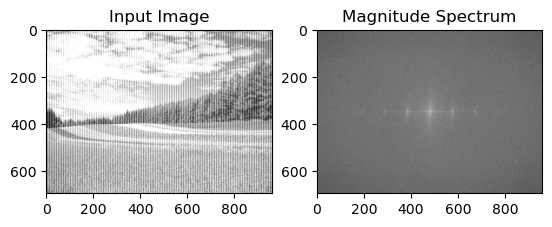

In [29]:
flower = grayscale_read('img/flower1.jpg')
fruit = grayscale_read('img/fruit.jpg')
horizontal_noise_img = grayscale_read('img/Noisy_flower1_horizontal.jpg')
vertical_noise_img = grayscale_read('img/Noisy_flower1_vertical.jpg')

process(fruit, "fruit")
process(flower, "flower")
process(horizontal_noise_img, "horizontal_noise")
process(vertical_noise_img, "vertical_noise")